In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from tensorflow.python.framework import function

import os, re

import claude.utils as cu
import claude.tx as tx
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh
import claude.claudeflow.training as cft

In [2]:
# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M = 16
chParam.w = int(np.log2(chParam.M))
if chParam.M == 16:
    chParam.SNR = 10
elif chParam.M == 64:
    chParam.SNR = 18
else:
    chParam.SNR = 22

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.seed = 1337
aeParam.constellationDim	= 2
aeParam.constellationOrder	= chParam.M
aeParam.nLayers		= 4
aeParam.nHidden 	= 256
aeParam.activation  = tf.nn.relu
aeParam.dropout		= False
aeParam.dtype       = tf.float32

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.sampleSize	= 16*chParam.M # Increase for better results (especially if M>16)
trainingParam.batchSize 	= 1*chParam.M  # Increase for better results (especially if M>16)
trainingParam.learningRate	= 0.001
trainingParam.displayStep	= 25
trainingParam.path			= 'results_GMI_AWGN'
trainingParam.filename		= 'M{:03d}_seed{:04d}_SNR{:02d}'.format(chParam.M,aeParam.seed,chParam.SNR)
trainingParam.earlyStopping = 25
trainingParam.iterations = 500
trainingParam.summaries = True

if trainingParam.summaries:
    # tensorboard directory
    chHyperParam = ['M','SNR']
    aeHyperParam = ['seed']
    trainingHyperParam = []

    trainingParam.summaryString = ','.join(  [ '{}={}'.format(item,chParam[item]) for item in chHyperParam ]
                                            +[ '{}={}'.format(item,trainingParam[item]) for item in trainingHyperParam ]
                                            +[ '{}={}'.format(item,aeParam[item]) for item in aeHyperParam ] )

    print(trainingParam.summaryString,flush=True)

M=16,SNR=10,seed=1337


In [3]:
# TF constants
one = tf.constant(1,aeParam.dtype)
two = tf.constant(2,aeParam.dtype)
DIM = tf.constant(aeParam.constellationDim,aeParam.dtype)
PI = tf.constant(np.pi,aeParam.dtype)

In [4]:
tf.set_random_seed(aeParam.seed)
np.random.seed(aeParam.seed)

# Tx Graph
allCombinations = cu.generateUniqueBitVectors(chParam.M)
xSeed = tf.constant(allCombinations, aeParam.dtype)
X = tf.placeholder( aeParam.dtype, shape=(None, chParam.w) )
enc, enc_seed = ae.encoder(X, aeParam, bits=True)

W0921 22:18:59.782160 139893023668032 deprecation.py:506] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
# Channel Graph
SNR_lin = cfh.dB2lin(tf.constant(chParam.SNR,aeParam.dtype),'dB')
sigma2_noise = one / SNR_lin
noise = tf.sqrt(sigma2_noise) * tf.rsqrt(two) * tf.random_normal(shape=tf.shape(enc),dtype=aeParam.dtype)
channel = enc + noise

In [6]:
# Rx Graph
decoder = ae.decoder(channel, aeParam, bits=True)
decoder_sigmoid = tf.sigmoid(decoder)

In [7]:
# Neural Network GMI metric
# the output of the neural network with sigmoid activation can serve as an LLR estimation :)
# we basically assume that the decoder neural network has learned a probability distribution of the channel
# which we use as auxiliary channel within the receiver
sigmoid_LLRs = tf.linalg.transpose( tf.log( (one-decoder_sigmoid) / decoder_sigmoid ) )
sigmoid_GMI = cfh.GMI( tf.linalg.transpose(X), sigmoid_LLRs )

# Gaussian GMI metric
# here we just use a Gaussian auxiliary channel assumption
constellation = tf.expand_dims( tf.complex( enc_seed[:,0], enc_seed[:,1]), axis=0 )
channel_complex = tf.expand_dims( tf.complex( channel[:,0], channel[:,1]), axis=0 )
gaussian_LLRs = cfh.gaussianLLR( constellation, tf.linalg.transpose(xSeed), channel_complex, SNR_lin, chParam.M )
gaussian_GMI = cfh.GMI( tf.linalg.transpose(X), gaussian_LLRs )

# In this script, the channel is a Gaussian channel, so a Gaussian auxiliary channel assumption is optimal
# Therefore: Gaussian GMI > Neural Network GMI

W0921 22:19:00.998221 139893023668032 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# bit errors and ber
input_bits = tf.cast( X , tf.int32 )
output_bits = tf.cast( tf.round( tf.nn.sigmoid( decoder ) ), tf.int32 )
bit_compare = tf.not_equal( output_bits, input_bits )
bit_errors = tf.reduce_sum( tf.cast( bit_compare, tf.int32 ) ) 
bit_error_rate = tf.reduce_mean( tf.cast( bit_compare, aeParam.dtype ) )

In [9]:
# loss
loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( labels=X, logits=decoder ) )
optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate)
d_sigmoid_loss = optimizer.minimize(loss)

In [10]:
metricsDict = {'loss_metric':loss,\
               'ber_metric':bit_error_rate,\
               'gaussian_gmi_metric':gaussian_GMI,\
               'sigmoid_gmi_metric':sigmoid_GMI}
meanMetricOpsDict, updateOps, resetOps = cft.create_mean_metrics(metricsDict)

W0921 22:19:03.500999 139893023668032 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [11]:
sess = tf.Session()

if trainingParam.summaries:
    weights_summaries = tf.summary.merge_all() # without weight/bias histograms
    # Summaries
    s = [tf.summary.scalar('BER', metricsDict['ber_metric']),
         tf.summary.scalar('loss', metricsDict['loss_metric']),
         tf.summary.scalar('gaussian_GMI', metricsDict['gaussian_gmi_metric']),
         tf.summary.scalar('sigmoid_GMI', metricsDict['sigmoid_gmi_metric'])]

    epoche_summaries = tf.summary.merge(s) # without weight/bias histograms

    summaries_dir = os.path.join(trainingParam.path,'tboard{}'.format(chParam.M),trainingParam.summaryString)
    os.makedirs(summaries_dir, exist_ok=True)

    train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
else:
    train_writer = None
        
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
checkpoint_path = os.path.join(trainingParam.path,'checkpoint',trainingParam.filename,'best')
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    pass
#     print("Restoring checkpoint...", flush=True)
#     saver.restore(sess=sess,save_path=checkpoint_path)

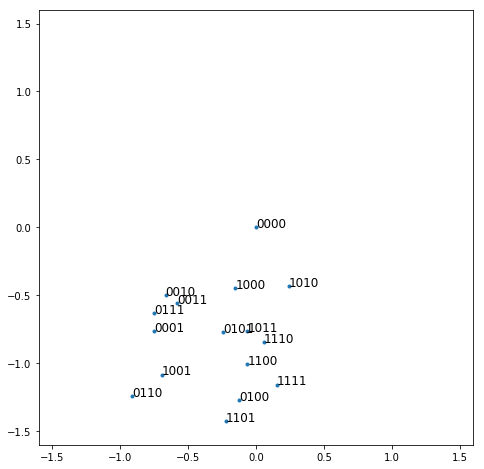

In [12]:
# constellation before training
[constellation,constellation_bits] = sess.run([enc_seed,xSeed])
plt.figure(figsize=(8,8))
plt.plot(constellation[:,0],constellation[:,1],'.')

for ii in range(constellation.shape[0]):
    bit_string = ''.join( [ str(int(x)) for x in allCombinations[ii,:].tolist()] )
    plt.text(constellation[ii,0], constellation[ii,1], bit_string, fontsize=12)
plt.axis('square');
lim_ = 1.6
plt.xlim(-lim_,lim_);
plt.ylim(-lim_,lim_);

In [13]:
bestLoss = 100000
bestAcc = 0
lastImprovement = 0
epoche = 0
nBatches = int(trainingParam.sampleSize/trainingParam.batchSize)
batchSizeMultiples = 1
batchSize = batchSizeMultiples * trainingParam.batchSize

np_loss = []
np_ber  = []
np_gaussian_gmi  = []
np_sigmoid_gmi  = []

### Comment on the training procedure:
The training gets stuck early when a large batch size is chosen. For this reason we start with a low batch size, and iterativley increase it after temporary convergence. Training with a low batch size introduces a more stochastic gradient estimation, which helps to get out of the local minima.

In [14]:
print( 'START TRAINING ... ', flush=True )
while(True):
    epoche = epoche + 1

    sess.run(resetOps)
    
    # train AE with iteratively increasing batch size
    for batch in range(0,nBatches):
        feedDict = {X: cu.generateBitVectors(batchSize,chParam.M)}
        sess.run(d_sigmoid_loss, feed_dict=feedDict)
    
    # gather performance metrics with large batch size
    for batch in range(0,nBatches):
        feedDict = {X: cu.generateBitVectors(trainingParam.sampleSize,chParam.M)}
        sess.run(updateOps, feed_dict=feedDict)

    [outAvgLoss, outAvgBer, outAvgGaussianGmi, outAvgSigmoidGmi] = sess.run(list(meanMetricOpsDict.values()), feed_dict=feedDict)

    np_loss.append( outAvgLoss )
    np_ber.append( outAvgBer )
    np_gaussian_gmi.append( outAvgGaussianGmi )
    np_sigmoid_gmi.append( outAvgSigmoidGmi )
    
    if trainingParam.summaries:
        epocheSummaries = sess.run(epoche_summaries, feed_dict=feedDict)
        train_writer.add_summary(epocheSummaries,epoche)

    if outAvgLoss < bestLoss:
        bestLoss = outAvgLoss
        lastImprovement = epoche
        saver.save(sess=sess,save_path=checkpoint_path)

    # convergence check and increase empirical evidence
    if epoche - lastImprovement > trainingParam.earlyStopping:

        saver.restore(sess=sess,save_path=checkpoint_path)
        bestLoss = 10000
        lastImprovement = epoche

        # increase empirical evidence
        batchSizeMultiples = batchSizeMultiples + 2
        batchSize = batchSizeMultiples * trainingParam.batchSize
        if batchSizeMultiples >= 17:
            break;

        print("batchSize: {}, batchSizeMultiples: {}".format(batchSize,batchSizeMultiples))

    if epoche%trainingParam.displayStep == 0:
        print('epoche: {:04d} - avgLoss: {:.2f} - avgBer: {:.2e} - avgGaussianGmi: {:.2f} - avgSigmoidGmi: {:.2f}'.format(epoche,outAvgLoss,outAvgBer,outAvgGaussianGmi,outAvgSigmoidGmi),flush=True)

START TRAINING ... 
epoche: 0025 - avgLoss: 0.24 - avgBer: 1.26e-01 - avgGaussianGmi: 2.90 - avgSigmoidGmi: 2.64
epoche: 0050 - avgLoss: 0.19 - avgBer: 7.64e-02 - avgGaussianGmi: 3.12 - avgSigmoidGmi: 2.92


W0921 22:19:22.073544 139893023668032 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


batchSize: 48, batchSizeMultiples: 3
epoche: 0075 - avgLoss: 0.17 - avgBer: 7.24e-02 - avgGaussianGmi: 3.16 - avgSigmoidGmi: 3.00
epoche: 0100 - avgLoss: 0.15 - avgBer: 6.42e-02 - avgGaussianGmi: 3.16 - avgSigmoidGmi: 3.11
batchSize: 80, batchSizeMultiples: 5
epoche: 0125 - avgLoss: 0.15 - avgBer: 6.26e-02 - avgGaussianGmi: 3.19 - avgSigmoidGmi: 3.12
epoche: 0150 - avgLoss: 0.16 - avgBer: 6.65e-02 - avgGaussianGmi: 3.15 - avgSigmoidGmi: 3.09
batchSize: 112, batchSizeMultiples: 7
epoche: 0175 - avgLoss: 0.16 - avgBer: 6.42e-02 - avgGaussianGmi: 3.15 - avgSigmoidGmi: 3.10
batchSize: 144, batchSizeMultiples: 9
epoche: 0200 - avgLoss: 0.15 - avgBer: 5.98e-02 - avgGaussianGmi: 3.17 - avgSigmoidGmi: 3.15
epoche: 0225 - avgLoss: 0.16 - avgBer: 6.23e-02 - avgGaussianGmi: 3.16 - avgSigmoidGmi: 3.11
batchSize: 176, batchSizeMultiples: 11
epoche: 0250 - avgLoss: 0.15 - avgBer: 6.20e-02 - avgGaussianGmi: 3.15 - avgSigmoidGmi: 3.13
epoche: 0275 - avgLoss: 0.15 - avgBer: 6.23e-02 - avgGaussianGmi: 3

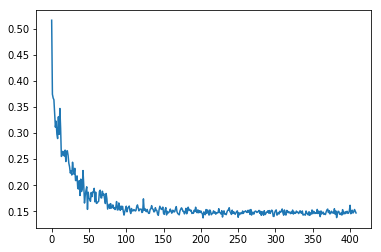

In [15]:
saver.restore(sess=sess,save_path=checkpoint_path)
np_loss = np.array( np_loss )
np_ber  = np.array( np_ber )
np_gaussian_gmi  = np.array( np_gaussian_gmi )
np_sigmoid_gmi  = np.array( np_sigmoid_gmi )
plt.plot( np_loss )

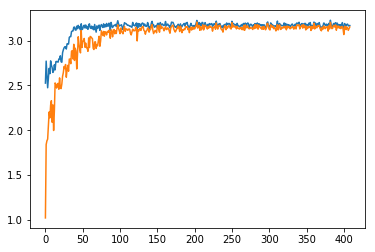

In [16]:
plt.plot( np_gaussian_gmi )
plt.plot( np_sigmoid_gmi )

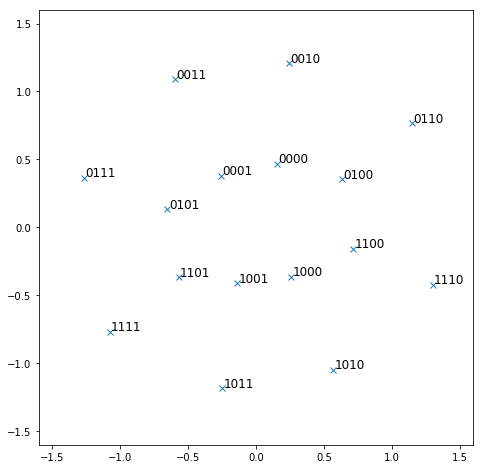

In [17]:
# constellation after training
[constellation,constellation_bits] = sess.run([enc_seed,xSeed])
plt.figure(figsize=(8,8))
plt.plot(constellation[:,0],constellation[:,1],'x')

for ii in range(constellation.shape[0]):
    bit_string = ''.join( [ str(int(x)) for x in allCombinations[ii,:].tolist()] )
    plt.text(constellation[ii,0]+0.01, constellation[ii,1]+0.01, bit_string, fontsize=12)
plt.axis('square');
lim_ = 1.6
plt.xlim(-lim_,lim_);
plt.ylim(-lim_,lim_);

In [18]:
sess.run(resetOps)
for batch in range(0,100):
    feedDict = {X: cu.generateBitVectors(1000,chParam.M)}
    sess.run(updateOps, feed_dict=feedDict)
[outAvgLoss, outAvgBer, outAvgGaussianGmi, outAvgSigmoidGmi] = sess.run(list(meanMetricOpsDict.values()), feed_dict=feedDict)
finalMetrics = { 'GaussianGMI': outAvgGaussianGmi, 'SigmoidGMI': outAvgSigmoidGmi, 'BER': outAvgBer, 'xentropy': outAvgLoss }

print( 'finalMetrics:', finalMetrics )

finalMetrics: {'GaussianGMI': 3.1765318, 'SigmoidGMI': 3.1487226, 'BER': 0.060694996, 'xentropy': 0.14751528}
